In [1]:
# data manipulation
from jetstream.bigquery_client import BigQueryClient
import numpy as np
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
#stats
from statsmodels.stats.proportion import proportion_confint
from sklearn.neighbors import KernelDensity
from scipy.stats import binom, norm, kstest, ttest_ind, mannwhitneyu
#misc
from tqdm import tqdm
import pickle as pkl

In [2]:
cache_path = 'simulation_dfs_4.pkl'

In [3]:
def sign(a):
    return (a > 0) - (a < 0)

In [4]:
def CI_to_Pvalue(point: float, lower: float, upper: float, point_null: float = 0.0) -> float:
    '''
    Converts a confidence interval for difference into a 2-sided p-value, 
    assuming large sample normal approximation for the CI
    '''
    if np.isclose(upper, lower):
        return np.nan
    standard_error = (upper - lower)/(2*1.96)
    z_score = (np.abs(point) - point_null)/standard_error
    return (1-norm.cdf(z_score))*2

In [5]:
USE_CACHE = False

In [6]:
if not USE_CACHE:
    dfs = dict()
    for simulation_iteration in tqdm(range(100)): 
        dataset = 'dberry_simulated_AA_tests_{:02d}'.format(simulation_iteration)
        client = BigQueryClient(project='moz-fx-data-experiments',dataset=dataset)
        try:
            overall_results_df = client.table_to_dataframe('statistics_more_from_mozilla_96_overall_1')
        except Exception:
            print(f'Table statistics_more_from_mozilla_96_overall_1 not found!')
            continue
            
        try:
            last_day_results_df = client.table_to_dataframe('statistics_more_from_mozilla_96_day_29')
        except Exception:
            print(f'Table statistics_more_from_mozilla_96_day_29 not found!')
            continue            
            
        sim_results_df = pd.concat([overall_results_df, last_day_results_df])
            
        if sim_results_df.shape[0] == 0:
            print(f'Simulation {simulation_iteration} empty!')
            continue
        comparisons_df = sim_results_df.loc[~sim_results_df.comparison.isnull()].copy()
        comparisons_df.loc[:, 'different_signs'] = (comparisons_df.lower.apply(sign) != comparisons_df.upper.apply(sign))
        comparisons_df.loc[:, 'both_zero'] = np.isclose(comparisons_df.lower.apply(sign) & comparisons_df.upper.apply(sign), 0)
        comparisons_df.loc[:, 'CI_contains_zero'] = comparisons_df[['different_signs', 'both_zero']].apply(
            lambda row: 'Yes' if row.different_signs else ('Both-zero' if row.both_zero else 'No'), 
            axis = 'columns'
        )
    
        dfs[simulation_iteration] = comparisons_df

    with open(cache_path, 'wb') as f:
        pkl.dump(dfs, f)
else:
    with open(cache_path, 'rb') as f:
        dfs = pkl.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:22<00:00,  6.82s/it]


In [7]:
with open(cache_path, 'rb') as f:
    df2s = pkl.load(f)

In [8]:
slug_cols = ['metric', 'statistic', 'parameter', 'branch', 'comparison', 'comparison_to_branch']

In [9]:
for i, df in dfs.items():
    df.loc[:, 'sim_number'] = i
    df.loc[:, 'result_slug'] = df.apply(lambda row: ':'.join(map(str, row[slug_cols])), axis = 'columns')
    df.loc[:, 'p-value'] = df.apply(lambda row: CI_to_Pvalue(row['point'], row['lower'], row['upper']), axis = 'columns')

# Analysis of p-value distributions

In [10]:
aggregate_df = pd.concat([df[[*slug_cols, 'result_slug', 'sim_number', 'p-value']] for df in dfs.values()])

In [11]:
results_pivot = aggregate_df.pivot(index=[*slug_cols, 'result_slug'], columns='sim_number')
sim_cols = ['sim_{:02d}'.format(i) for i in results_pivot.columns.droplevel(0)]
results_pivot.columns = sim_cols
results_pivot = results_pivot.reset_index()

In [12]:
results_no_NAs = results_pivot.loc[results_pivot[sim_cols].isna().mean(axis=1) == 0].copy()
results_NAs = results_pivot.loc[results_pivot[sim_cols].isna().mean(axis=1) != 0].copy()

In [13]:
results_no_NAs.loc[:, 'ks_test_pvalue'] = results_no_NAs.apply(lambda row: kstest(list(row[sim_cols]), 'uniform').pvalue, axis = 'columns')

# Aggregate Results

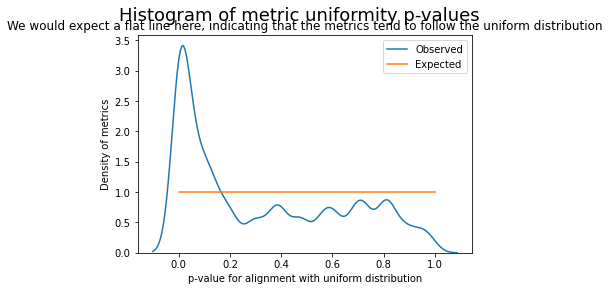

In [14]:
sns.kdeplot(results_no_NAs.ks_test_pvalue, bw_adjust=0.3, label = 'Observed')
sns.lineplot(x=[0,1],y=[1,1], label='Expected')
plt.xlabel('p-value for alignment with uniform distribution')
plt.ylabel('Density of metrics')
plt.suptitle('Histogram of metric uniformity p-values', fontsize=18)
plt.title('We would expect a flat line here, indicating that the metrics tend to follow the uniform distribution')
plt.show()

In [15]:
# Test for all metrics following uniform distribution is rejected, more metrics are rejected than expected

In [16]:
kstest(list(results_no_NAs.ks_test_pvalue), 'uniform')

KstestResult(statistic=0.31199536572791764, pvalue=2.2556690057331496e-15)

In [17]:
(
    results_no_NAs
    .loc[results_no_NAs.ks_test_pvalue < 0.05]
    .sort_values('ks_test_pvalue')
    .drop(columns = sim_cols)
    .to_csv('metric_kstest_pvalues.csv', index = False)
)

In [18]:
# would expect this to be .95 if everything calibrated properly
(results_no_NAs.ks_test_pvalue > 0.05).mean()

0.6976744186046512

## Ten metrics most significantly non-uniform

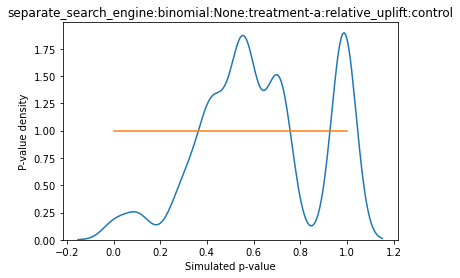

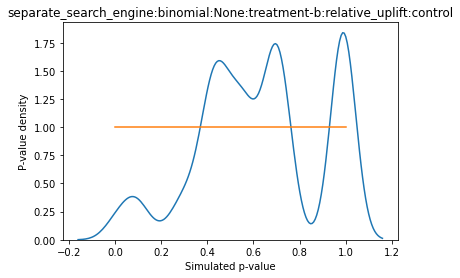

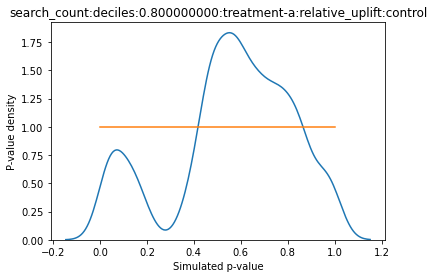

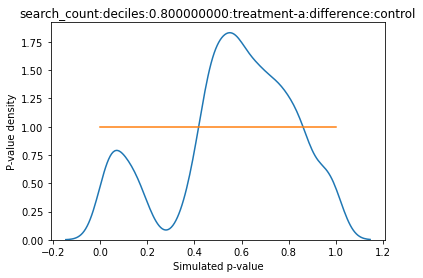

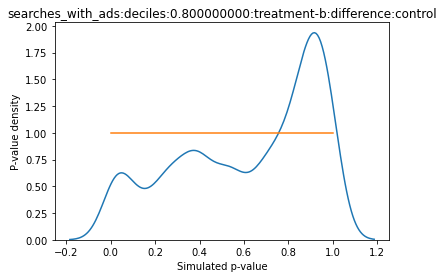

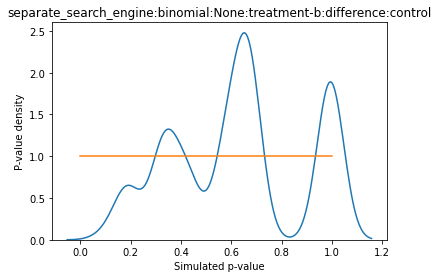

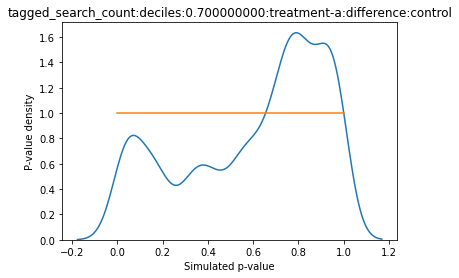

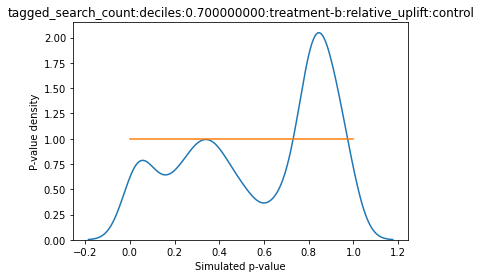

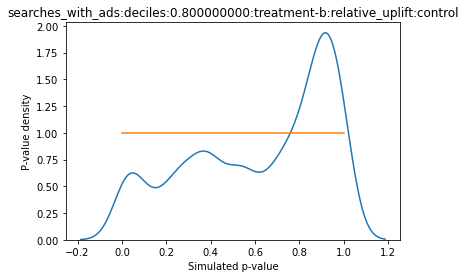

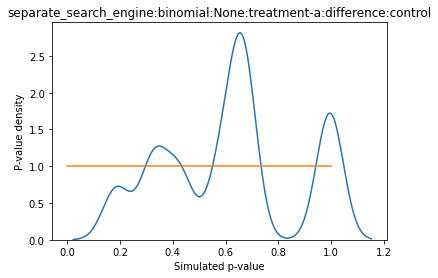

In [19]:
for _, row in results_no_NAs.sort_values('ks_test_pvalue').head(10).iterrows():
    sns.kdeplot(row[sim_cols], bw_adjust=0.5)
    sns.lineplot(x=[0,1],y=[1,1])
    plt.title(row['result_slug'])
    plt.xlabel('Simulated p-value')
    plt.ylabel('P-value density')
    plt.show()

In [20]:
results_pivot.metric.value_counts()

active_hours                     40
ad_clicks                        40
days_of_use                      40
organic_search_count             40
search_count                     40
searches_with_ads                40
tagged_follow_on_search_count    40
tagged_search_count              40
uri_count                        40
retained                          4
separate_search_engine            4
unenroll                          4
Name: metric, dtype: int64

In [21]:
results_NAs.metric.value_counts()

ad_clicks                        36
organic_search_count             32
searches_with_ads                30
tagged_follow_on_search_count    28
days_of_use                      26
search_count                     24
tagged_search_count              24
Name: metric, dtype: int64

In [22]:
results_no_NAs.metric.value_counts()

active_hours                     40
uri_count                        40
search_count                     16
tagged_search_count              16
days_of_use                      14
tagged_follow_on_search_count    12
searches_with_ads                10
organic_search_count              8
ad_clicks                         4
retained                          4
separate_search_engine            4
unenroll                          4
Name: metric, dtype: int64

In [23]:
def plot_pvalue_distribution_for_metric(metric: str, statistic: str, branch: str, comparison: str, bw_adjust=0.3) -> None:
    row = results_no_NAs.loc[(
        (results_no_NAs.metric == metric) &
        (results_no_NAs.statistic == statistic) &
        (results_no_NAs.branch == branch) &
        (results_no_NAs.comparison == comparison)
    )].iloc[0]
    print('KS test for follows uniform distribution p-value: {:0.4f}'.format(row.ks_test_pvalue))
    sns.kdeplot(row[sim_cols], bw_adjust=bw_adjust, label='Actual')
    sns.lineplot(x=[0,1],y=[1,1], label='Expected')
    plt.title(row['result_slug'])
    plt.xlabel('Simulated p-value')
    plt.ylabel('P-value density')
    plt.show()
    

## Retention

KS test for follows uniform distribution p-value: 0.7092


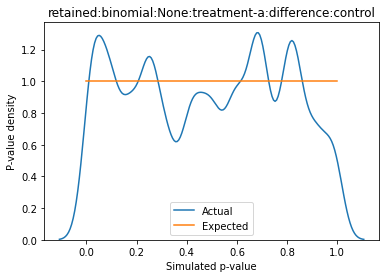

In [24]:
plot_pvalue_distribution_for_metric('retained', 'binomial', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.8036


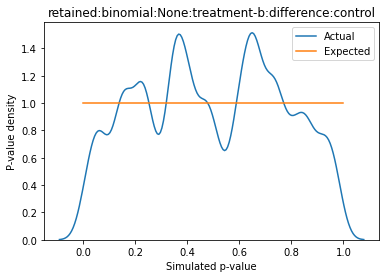

In [25]:
plot_pvalue_distribution_for_metric('retained', 'binomial', 'treatment-b', 'difference')

## Active Hours

KS test for follows uniform distribution p-value: 0.1842


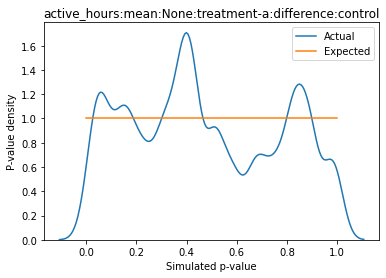

In [26]:
plot_pvalue_distribution_for_metric('active_hours', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.3861


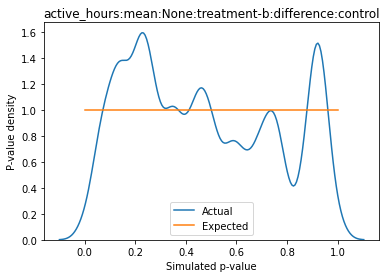

In [27]:
plot_pvalue_distribution_for_metric('active_hours', 'mean', 'treatment-b', 'difference')

## Days of Use

KS test for follows uniform distribution p-value: 0.9512


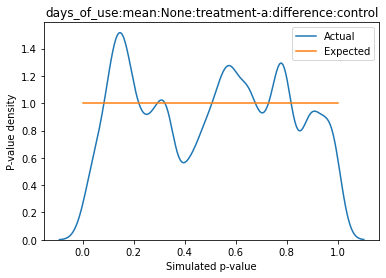

In [28]:
plot_pvalue_distribution_for_metric('days_of_use', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.1162


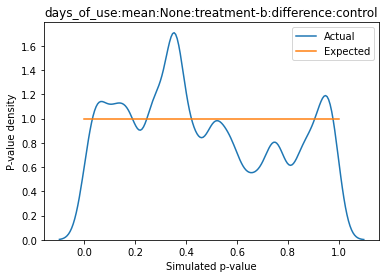

In [29]:
plot_pvalue_distribution_for_metric('days_of_use', 'mean', 'treatment-b', 'difference')

## URI Count

KS test for follows uniform distribution p-value: 0.8055


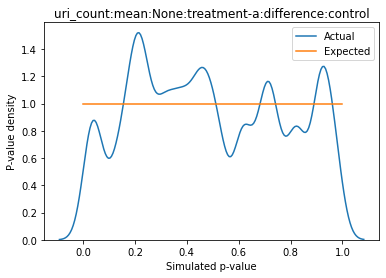

In [30]:
plot_pvalue_distribution_for_metric('uri_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.0655


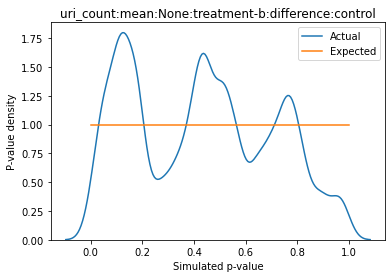

In [31]:
plot_pvalue_distribution_for_metric('uri_count', 'mean', 'treatment-b', 'difference')

## Search Count

KS test for follows uniform distribution p-value: 0.7824


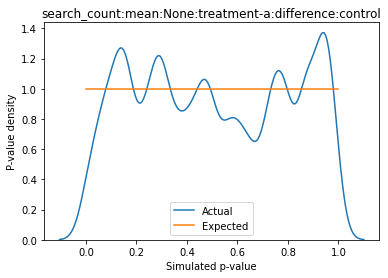

In [32]:
plot_pvalue_distribution_for_metric('search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.1264


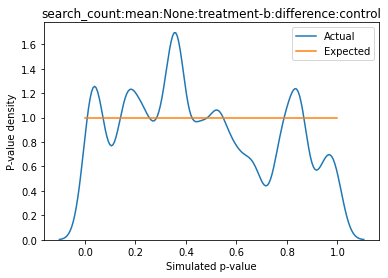

In [33]:
plot_pvalue_distribution_for_metric('search_count', 'mean', 'treatment-b', 'difference')

## Tagged Search Count

KS test for follows uniform distribution p-value: 0.6729


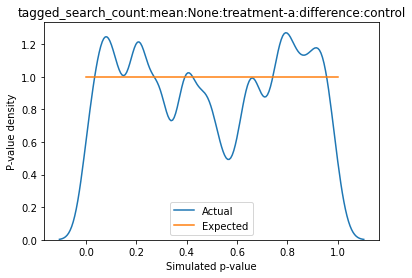

In [34]:
plot_pvalue_distribution_for_metric('tagged_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.1024


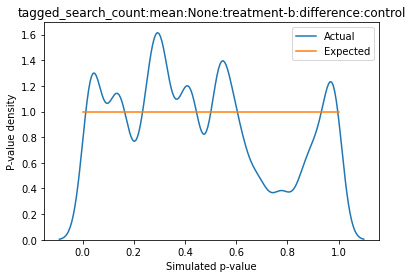

In [35]:
plot_pvalue_distribution_for_metric('tagged_search_count', 'mean', 'treatment-b', 'difference')

## Tagged Follow On Search Count

KS test for follows uniform distribution p-value: 0.0407


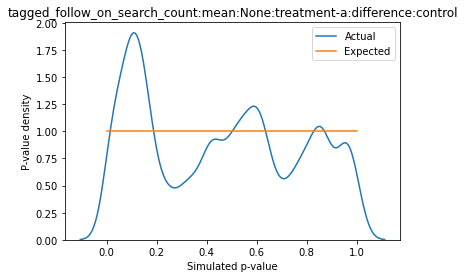

In [36]:
plot_pvalue_distribution_for_metric('tagged_follow_on_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.0417


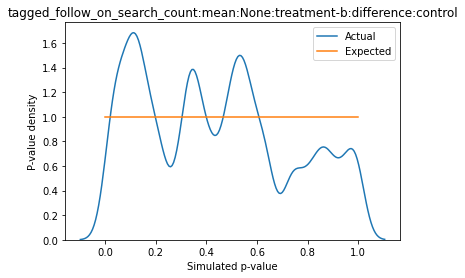

In [37]:
plot_pvalue_distribution_for_metric('tagged_follow_on_search_count', 'mean', 'treatment-b', 'difference')

## Searches With Ads

KS test for follows uniform distribution p-value: 0.2193


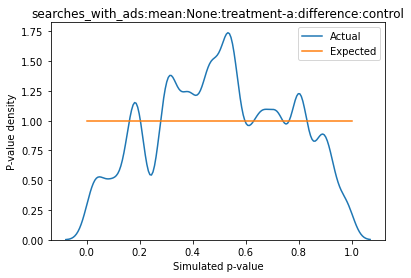

In [38]:
plot_pvalue_distribution_for_metric('searches_with_ads', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.3832


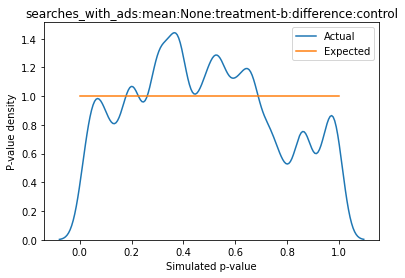

In [39]:
plot_pvalue_distribution_for_metric('searches_with_ads', 'mean', 'treatment-b', 'difference')

## Ad Clicks

KS test for follows uniform distribution p-value: 0.4849


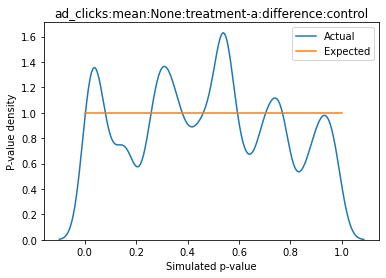

In [40]:
plot_pvalue_distribution_for_metric('ad_clicks', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.7250


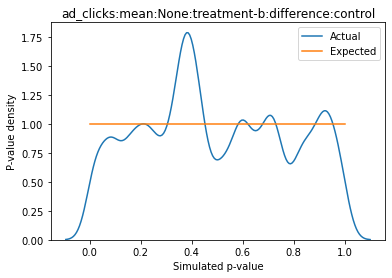

In [41]:
plot_pvalue_distribution_for_metric('ad_clicks', 'mean', 'treatment-b', 'difference')

## Organic Search Count

KS test for follows uniform distribution p-value: 0.0007


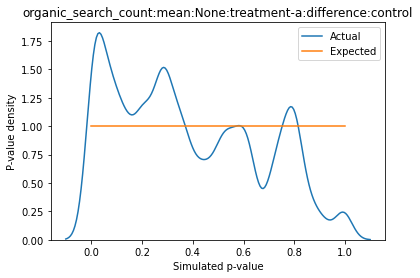

In [42]:
plot_pvalue_distribution_for_metric('organic_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.0064


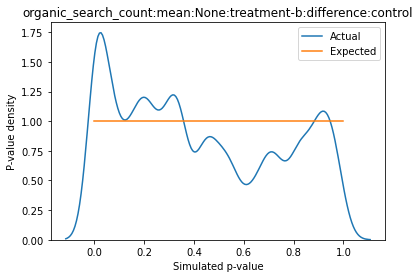

In [43]:
plot_pvalue_distribution_for_metric('organic_search_count', 'mean', 'treatment-b', 'difference')

## Separate Search Engine

In [44]:
# Odd behavior here likely due to extremely rare occurrences

KS test for follows uniform distribution p-value: 0.0001


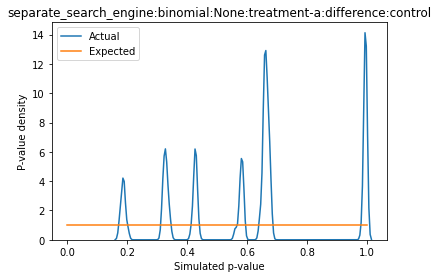

In [45]:
plot_pvalue_distribution_for_metric('separate_search_engine', 'binomial', 'treatment-a', 'difference', bw_adjust=0.05)

KS test for follows uniform distribution p-value: 0.0000


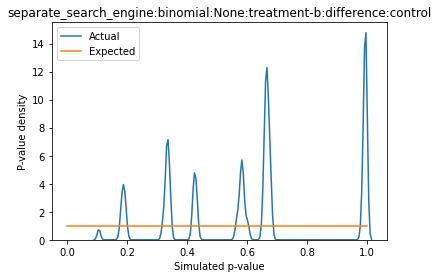

In [46]:
plot_pvalue_distribution_for_metric('separate_search_engine', 'binomial', 'treatment-b', 'difference', bw_adjust=0.05)

## Test core metrics for distributional accuracy

In [47]:
core_metrics = pd.DataFrame([
    ('retained', 'binomial'),
    ('active_hours', 'mean'),
    ('days_of_use', 'mean'),
    ('uri_count', 'mean'),
    ('search_count', 'mean'),
    ('tagged_search_count', 'mean'),
    ('tagged_follow_on_search_count', 'mean'),
    ('organic_search_count','mean'),
    ('searches_with_ads', 'mean'),
    ('ad_clicks', 'mean'),
    ('separate_search_engine', 'binomial')
], columns = ['metric', 'statistic'])

In [48]:
core_pvals = results_no_NAs.merge(core_metrics, on=['metric', 'statistic']).query('comparison=="difference"').ks_test_pvalue

In [49]:
from statsmodels.stats.multitest import multipletests

In [50]:
reject, core_pvals_corrected, alphacSidak, alphacBonf = multipletests(core_pvals, method='holm')

In [51]:
reject.sum()

3

In [52]:
results_no_NAs.merge(core_metrics, on=['metric', 'statistic']).query('comparison=="difference"')[reject]

,metric,statistic,parameter,branch,comparison,comparison_to_branch,result_slug,sim_00,sim_01,sim_02,...,sim_91,sim_92,sim_93,sim_94,sim_95,sim_96,sim_97,sim_98,sim_99,ks_test_pvalue
12,organic_search_count,mean,NaN,treatment-a,difference,control,organic_search_count:mean:None:treatment-a:dif...,0.741920,0.195073,0.483956,...,0.418853,0.792661,0.197122,0.239244,0.018240,0.799781,0.704996,0.267470,0.272765,0.000703
28,separate_search_engine,binomial,NaN,treatment-a,difference,control,separate_search_engine:binomial:None:treatment...,0.175624,0.430852,0.666366,...,0.331387,0.994675,0.660701,0.679759,0.660501,0.997064,0.995176,0.415934,0.178939,0.000051
30,separate_search_engine,binomial,NaN,treatment-b,difference,control,separate_search_engine:binomial:None:treatment...,0.568904,0.195008,0.997009,...,0.996415,0.660519,0.989709,0.680585,0.667352,0.334495,0.333527,0.580869,0.583736,0.000027


In [53]:
kstest(core_pvals, 'uniform')

KstestResult(statistic=0.32813690645144744, pvalue=0.013048806620232778)

# Skewness Study

In [54]:
client = BigQueryClient(project='moz-fx-data-experiments',dataset='dberry_simulated_AA_tests_03')

In [55]:
enrollments_raw = client.table_to_dataframe('more_from_mozilla_96_enrollments_overall_1')

In [56]:
organic_searches = enrollments_raw.organic_search_count

In [57]:
organic_search_counts = organic_searches.value_counts().sort_index()

In [58]:
organic_searches.mean()

20.878081626770957

In [59]:
organic_search_counts.mean()

334.27408637873754

In [60]:
organic_search_counts

0        385600
1         40102
2         21264
3         14022
4         10229
          ...  
8397          1
8468          1
9713          1
12811         1
12899         1
Name: organic_search_count, Length: 1806, dtype: int64

<AxesSubplot:xlabel='organic_search_count', ylabel='Density'>

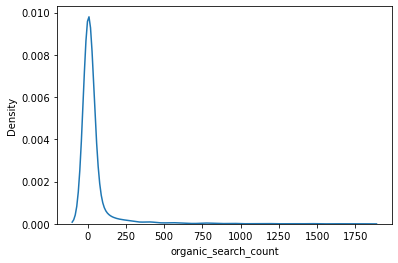

In [61]:
sns.kdeplot(organic_search_counts[(organic_search_counts < organic_search_counts.quantile(q = .99))])

In [62]:
organic_search_counts_cdf = organic_search_counts.cumsum()/organic_search_counts.sum()

In [63]:
st.expon.stats(loc=0, scale=300)

NameError: name 'st' is not defined

In [ ]:
sns.lineplot(xplot, st.expon.pdf(xplot, loc=0, scale=300))

In [ ]:
from random import choices

In [ ]:
def sample_with_mean_adjustment(pct_increase: float):
    '''Returns a sample from the emperical distribution, with a mean adjusted by `pct_increase`
    '''
    base_sample = np.asarray(sample(list(organic_searches), len(organic_searches)))
    adj_mean = pct_increase * organic_searches.mean()
    adjustments = np.floor(st.expon.rvs(loc = 0, scale = adj_mean, size = len(base_sample)))
    return base_sample + adjustments
    

In [ ]:
pct_increases = np.arange(0, .1, .01)
pct_increase_frac_reject = []
for pct_increase in tqdm(pct_increases):
    did_reject = []
    for sub_iter in range(100):
        base_sample = np.asarray(choices(list(organic_searches), k=len(organic_searches)))
        test_sample = np.asarray(choices(list(organic_searches), k=len(organic_searches)))
        test_result = ttest_ind(base_sample, test_sample)
        did_reject.append(test_result.pvalue < 0.05)
    pct_increase_frac_reject.append(np.mean(did_reject))

In [ ]:
pct_increase_frac_reject_mw = []
for pct_increase in tqdm(pct_increases):
    did_reject = []
    for sub_iter in range(100):
        base_sample = np.asarray(choices(list(organic_searches), k=len(organic_searches)))
        test_sample = np.asarray(choices(list(organic_searches), k=len(organic_searches))) # sample_with_mean_adjustment(pct_increase)
        test_result = mannwhitneyu(base_sample, test_sample)
        did_reject.append(test_result.pvalue < 0.05)
    pct_increase_frac_reject_mw.append(np.mean(did_reject))

In [ ]:
base_sample = np.asarray(sample(list(organic_searches), len(organic_searches)))
        test_sample = np.asarray(sample(list(organic_searches), len(organic_searches)))

In [ ]:
np.mean(base_sample)

In [ ]:
np.std(base_sample)/np.mean(base_sample)

In [ ]:
np.mean(test_sample)

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=pct_increases, y=pct_increase_frac_reject)
plt.xlim((0,.1))
ax.xaxis.set_major_formatter(PercentFormatter(1.0)) 
ax.yaxis.set_major_formatter(PercentFormatter(1.0)) 
plt.xlabel('Percent change in mean')
plt.ylabel('Statistical Power (probability of detecting change)')
plt.title('Observed power for t test on highly skewed Organic Search Count data')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=pct_increases, y=pct_increase_frac_reject_mw)
plt.xlim((0,.1))
ax.xaxis.set_major_formatter(PercentFormatter(1.0)) 
ax.yaxis.set_major_formatter(PercentFormatter(1.0)) 
plt.xlabel('Percent change in mean')
plt.ylabel('Statistical Power (probability of detecting change)')
plt.title('Observed power for t test on highly skewed Organic Search Count data')
plt.show()

In [ ]:
from random import sample

In [ ]:
from scipy.stats._continuous_distns import _distn_names
import scipy.stats as st
import warnings

# Sourced From: https://stackoverflow.com/a/37616966

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [ ]:
best_distibutions = best_fit_distribution(enrollments_raw.organic_search_count, 200, None)
best_dist = best_distibutions[0]

In [ ]:
best_distibutions

In [ ]:
best_dist, params, sse = best_distibutions[2]

In [ ]:
best_dist

In [ ]:
sns.kdeplot(organic_search_counts[(organic_search_counts < 1000)], bw_adjust=.1)
xplot = np.arange(0,1000,10)
plt.plot(xplot, best_dist.pdf(xplot, *params))

# Methodology Validation
Demonstrate that the Kolmogorov–Smirnov test is consistent under the null hypothesis that metric p-values have uniform distributions

In [ ]:
from scipy.stats import uniform
from joblib import Parallel, delayed

In [ ]:
def run_sim(i):
    simulated_simulation_pvalues = pd.DataFrame(uniform.rvs(size=(100,100), random_state = i), columns = range(100))
    pvals = simulated_simulation_pvalues.apply(lambda row: kstest(list(row), 'uniform').pvalue, axis = 'columns')
    return kstest(pvals, 'uniform').pvalue

In [ ]:
%%time
validation_pvals = Parallel(n_jobs=8)(delayed(run_sim)(i) for i in range(10000))

In [ ]:
sns.kdeplot(validation_pvals, bw_adjust=0.3, label = 'Observed (simulated)')
sns.lineplot(x=[0,1],y=[1,1], label='Expected')
plt.xlabel('p-value for alignment with uniform distribution')
plt.ylabel('Density of metrics')
plt.suptitle('Histogram of metric uniformity p-values', fontsize=18)
plt.title('We would expect a flat line here, indicating that the metrics tend to follow the uniform distribution')
plt.show()

In [ ]:
kstest(validation_pvals, 'uniform')

# Analysis using CI contains-zero methodology

In [ ]:
return ValueError('Work in progress')

In [ ]:
aggregate_df = pd.concat([df[['result_slug', 'sim_number', 'CI_contains_zero']] for df in dfs.values()])

In [ ]:
results_pivot = aggregate_df.pivot(index='sim_number', columns='result_slug')

In [ ]:
results_pivot.columns = results_pivot.columns.droplevel(0)

In [ ]:
prop_sims_with_zero_width_CIs = results_pivot.apply(lambda col: (col == 'Both-zero').mean())

In [ ]:
prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs > 0]

In [ ]:
results_positive_width = results_pivot[prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs == 0].index]

In [ ]:
success_rates = (results_positive_width == 'Yes').mean()
sns.distplot(success_rates)

In [ ]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(np.asarray(success_rates).reshape(-1, 1))
X_plot = np.linspace(.75, 1.05, 1000).reshape(-1,1)
dens = np.exp(kde.score_samples(X_plot))

In [ ]:
n_metrics = len(results_positive_width.columns)
null_metric_success_probability = 0.95

In [ ]:
ax = plt.subplots(figsize = (20,10))
sns.lineplot(x=X_plot[:,0], y=dens/dens.sum(), label='Observed')
sns.lineplot(x=np.arange(0,1+1/n_metrics,1/n_metrics), 
             y = binom.pmf(range(n_metrics+1), n_metrics, null_metric_success_probability) * 1/n_metrics, label = 'Theoretical')
plt.xlim((0.7,1.0))
plt.show()